In [1]:
from cppbridge import *
from mcmc_analytics import *
plt.rcParams['font.size'] = '16'

In [2]:
%load_ext autoreload
%autoreload 2

# Checking Metropolitan and EHMM samplers with non-linear non-Gaussian models

The experiments are for the models and samplers presented in the paper\
[1] Shestopaloff A.Y, Neal R.M. Sampling Latent States for High-Dimensional Non-Linear State Space Models with the Embedded HMM Method

---
## Model specification

### Transition model  
For transition model we take the same VAR(1) model as with linear gaussian experiments.

In [3]:
# Set up the transition model with parameters above
T = 500
n = 15
A = DiagonalMatrixParam()
A.value = np.eye(n) * 0.9
Q = SymmetricMatrixParam()
Q.value = np.ones((n,n)) * 0.7 + np.eye(n) * 0.3
prior_mean = np.zeros(n)
Q_init = Q.value * (1/(1-0.9*0.9))
trm = TransitionSpec(A, Q, prior_mean, Q_init)

### Observation model
The observation model is Poisson bimodal model

In [4]:
# Set up the Poisson observation model
sigma = VectorParam()
sigma.value = 0.8 * np.ones(n)
obsm = ObservationSpec(ModelType.BIMODAL_POISSON, sigma)

## Samplers specification
### Metropolis sampling scheme

In [5]:
# Specify metropolis scheme
met_sampler = SamplerSpec(SamplerType.METROPOLIS)

### Embedded HMM sampling scheme
For the second Poisson model we use flip updates in addition to autoregressive and shift update, alternating between them for each step in Markov chain generating the state pools.

In [6]:
# Specify EHMM schemes for both models
pool_sz = 80
ehmm_sampler = SamplerSpec(SamplerType.EHMM, pool_size=pool_sz, flip=True)

## Observations 
We use the synthetic data generated in `models.ipynb` notebook.

In [7]:
# We use the data file generated previously
dg = DataGenerator(trm, obsm, T, 200434834)
datafile = f"{dg.modelhash}_data.h5"
dataspec = Data(datafile)

## Simulation
### Single-state Metropolis MCMC
To run the simulation we need to provide the initial sample $\mathbf{x}_0$ to start off the sampler, and specify the parameters of the simulation. We set $\mathbf{x}_0=\mathbf{1}$ for both schemes. We run 5 simulations for $10^6$ iterations each, starting with the different seed for randomisation. To save memory we thin the sampling, only recording each tenth sample.

In [8]:
n_iter_met = int(1e6)
seeds = np.array([1, 10, 100, 1e4, 1e5], dtype=int)
scales_met = np.array([0.2, 0.8])
thinning = 10
x_init = np.ones((n, T))
simulation_met = SimulationSpec(n_iter_met, seeds, x_init, thinning=thinning, scaling=scales_met)

In [9]:
# Simulation with Metropolitan single state sampler
met_session_name = f"met_noreverse_{dg.modelhash}"
mcmc_met_bi = MCMCsession(met_session_name)
if mcmc_met_bi.hasResults():
    mcmc_met_bi.loadResults() # <-- NB! Each file is ~6GB so it takes time to download
else:
    mcmc_met_bi.init(T, trm, obsm, met_sampler, simulation_met, dataspec)
    mcmc_met_bi.run()

Launched Baysis
Loaded model specifications.

Running sampler for met_noreverse_gauss_poiss2_3225125971228064704 with 5 seeds:
	running with seed 1 ...
	Done in 1518675ms
	results saved into ../data/met_noreverse_gauss_poiss2_3225125971228064704_results_seed1.h5

	running with seed 10 ...
	Done in 1726036ms
	results saved into ../data/met_noreverse_gauss_poiss2_3225125971228064704_results_seed10.h5

	running with seed 100 ...
	Done in 1890544ms
	results saved into ../data/met_noreverse_gauss_poiss2_3225125971228064704_results_seed100.h5

	running with seed 10000 ...
	Done in 1486328ms
	results saved into ../data/met_noreverse_gauss_poiss2_3225125971228064704_results_seed10000.h5

	running with seed 100000 ...
	Done in 1497642ms
	results saved into ../data/met_noreverse_gauss_poiss2_3225125971228064704_results_seed100000.h5

######### All done #########
Loading results for seed100000...		Done
Loading results for seed1...		Done
Loading results for seed10...		Done
Loading results for seed

### Embdedded HMM MCMC
For EHMM smapler we run 5 simulations for $10000$ iterations each, starting with the different seed for randomisation (we use the same seeds as for single state sampler). Each iteration will run on both original and reversed sequence of observations.

In [10]:
%%html
<p style="color:red">RECOMPILE BAYSIS BEFORE RUNNING THE CELLS BELOW!</p>

In [15]:
n_iter_ehmm = 10000
scales_ehmm = np.array([0.05, 0.2])
reverse = True
simulation_ehmm = SimulationSpec(n_iter_ehmm, seeds, x_init, scaling=scales_ehmm, reverse=reverse)

In [16]:
# Simulation with EHMM sampler
ehmm_session_name = f"ehmm80_reverse_{dg.modelhash}"
mcmc_ehmm_bi = MCMCsession(ehmm_session_name)
if mcmc_ehmm_bi.hasResults():
    mcmc_ehmm_bi.loadResults()
else:
    mcmc_ehmm_bi.init(T, trm, obsm, ehmm_sampler, simulation_ehmm, dataspec)
    mcmc_ehmm_bi.run()

Launched Baysis
Loaded model specifications.
HighFive WARNING "reverse": data and hdf5 dataset have different types: Integer8 -> Enum8
HighFive WARNING "flip": data and hdf5 dataset have different types: Integer8 -> Enum8

Running sampler for ehmm50_reverse_gauss_poiss2_3225125971228064704 with 5 seeds:
	running with seed 1 ...
	Done in 2348945ms
	results saved into ../data/ehmm50_reverse_gauss_poiss2_3225125971228064704_results_seed1.h5

	running with seed 10 ...
	Done in 2383259ms
	results saved into ../data/ehmm50_reverse_gauss_poiss2_3225125971228064704_results_seed10.h5

	running with seed 100 ...
	Done in 2405459ms
	results saved into ../data/ehmm50_reverse_gauss_poiss2_3225125971228064704_results_seed100.h5

	running with seed 10000 ...
	Done in 2384914ms
	results saved into ../data/ehmm50_reverse_gauss_poiss2_3225125971228064704_results_seed10000.h5

	running with seed 100000 ...
	Done in 2383094ms
	results saved into ../data/ehmm50_reverse_gauss_poiss2_3225125971228064704_resu

---
## Analysis of the results for Poisson model 1
### Overview

In [ ]:
met_burnin = int(0.1 * (n_iter_met/thinning + 1))
ehmm_burnin = int(0.1 * 2 * (n_iter_ehmm + 1)) # <-- as we run on reversed sequence, too, there will be twice as many samples

met_samples = mcmc_met_bi.get_samples(met_burnin)
ehmm_samples = mcmc_ehmm_bi.get_samples(ehmm_burnin)

In [ ]:
ac_ehmm = getACF(mcmc_ehmm_bi.samples, ehmm_samples)
taus_ehmm = 1 + 2*np.sum(ac_ehmm, axis=2)
meantaus_ehmm = np.mean(taus_ehmm)

ac_met = getACF(mcmc_met_bi.samples, met_samples)
taus_met = 1 + 2*np.sum(ac_met, axis=2)
meantaus_met = np.mean(taus_met)

In [ ]:
met_overview = {"Num seeds": len(seeds),
                "Num iter": n_iter_met,
                "Time per sample, ms": np.mean(list(mcmc_met_bi.durations.values())) / list(mcmc_met_bi.samples.values())[0].shape[0],
                "Acceptance rate, %": 100 * np.mean(list(mcmc_met_bi.acceptances.values())) / n_iter_met,
                "Average autocorrelation time": meantaus_met
                }

ehmm_met_acc = 100 * np.mean([acc[:T].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_bi.acceptances.items()])
ehmm_shift_acc = 100 * np.mean([acc[T+1:].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_bi.acceptances.items()])
ehmm_overview = {"Num seeds": len(seeds),
                 "Num iter": n_iter_ehmm,
                 "Time per sample, ms": np.mean(list(mcmc_ehmm_bi.durations.values())) / list(mcmc_ehmm_bi.samples.values())[0].shape[0],
                 "Acceptance rate, %": (ehmm_met_acc, ehmm_shift_acc),
                 "Average autocorrelation time": meantaus_ehmm
                 }
overview = pd.DataFrame({"Single-state Metropolis":met_overview, "Embedded HMM":ehmm_overview}).T
overview['Average autocorrelation time'] *= overview['Time per sample, ms']
overview

In [ ]:
met_ar = np.array(list(mcmc_met_bi.acceptances.values())).ravel() / n_iter_met
ehmm_ar = np.stack(list(mcmc_ehmm_bi.acceptances.values()), axis=1)[:T].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
ehmm_shift = np.stack(list(mcmc_ehmm_bi.acceptances.values()), axis=1)[T + 1:].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
pd.DataFrame(dict(met_ar=met_ar, ehmm_ar=ehmm_ar, ehmm_shift=np.append(ehmm_shift, [np.nan]*len(seeds)))).describe()

In [ ]:
overview.to_latex(OUTPUTS_PATH/"overview_bp.tex", column_format="rrrrrr", escape=True, caption="Overview of the two samplers")

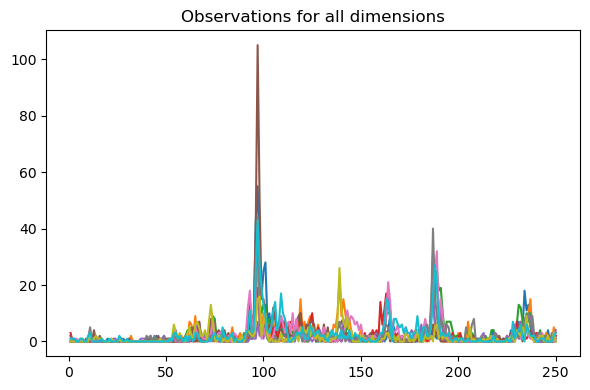

In [85]:
# Plot the observations for all dimensions across time
xs = np.array(range(1, T+1))
for name, series in {"y":dg.observations, "x":dg.states}.items():
    fig, ax = plt.subplots(figsize=(8,5))
    for i in range(n):
        ax.plot(xs, series[i, :], color=f'C{i}')
    ax.set_xmargin(0.01)
    ax.set_xlabel("time $t$")
    ax.set_ylabel(f"${{{name}}}$")
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH/f"generated_bp_{name}s.png", dpi=300, format='png')
    plt.show();

### Convergence analysis

In [175]:
epsr = getEPSR(mcmc_ehmm_bi.samples, ehmm_burnin)

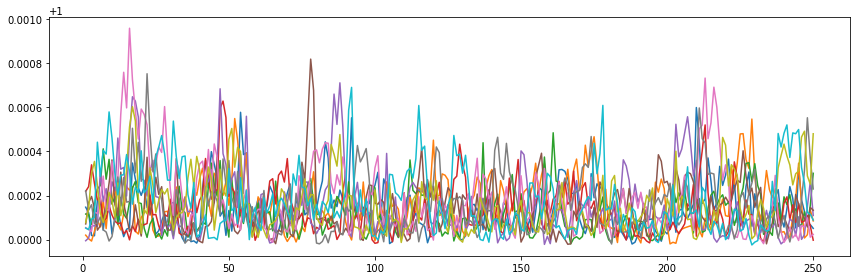

In [176]:
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, epsr[:, i])
plt.tight_layout()
plt.show();

In [177]:
ac = getACF(mcmc_ehmm_bi.samples, ehmm_burnin)
taus = 1 + 2*np.sum(ac, axis=2)

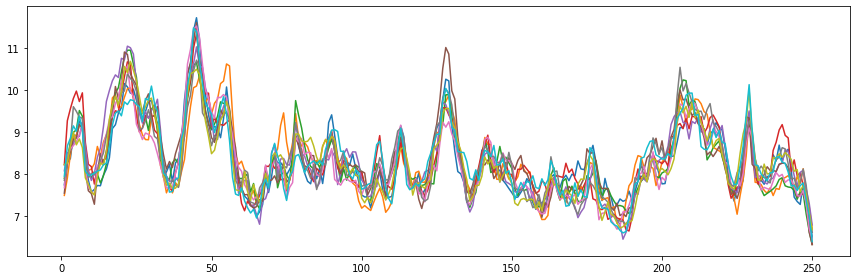

In [178]:
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, taus[i, :])
plt.tight_layout()
plt.show();

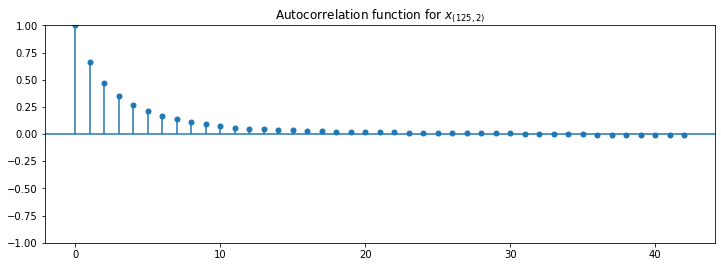

In [179]:
fig, ax = plt.subplots(figsize=(10,4))
plotACF(ac, 125, 2, ax)

### Trace plots

In [ ]:
# Check mixing of different seeds
plot_mixing(mcmc_ehmm_bi.samples, 0, 0, save="ehmm_bp")

In [ ]:
# Trace plots of a couple of particles
plot_trace(ehmm_samples, 249, 9, save="ehmm_bp")